In [395]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import optuna
from datetime import datetime, date, time
%matplotlib inline

# добавляем в графики красивости seaborn:
sns.set_style('whitegrid')

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (AdaBoostClassifier, GradientBoostingClassifier,
                              RandomForestClassifier, ExtraTreesClassifier)
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, confusion_matrix, roc_curve, roc_auc_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from optuna.visualization import plot_optimization_history, plot_param_importances
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.base import clone
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

import pandas_profiling

pd.set_option('display.max_columns', 200)

In [339]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [ ]:
# Конвертируем датасет из формата xlsx в csv

# def xlsx_to_csv_pd():
    # data_xls = pd.read_excel('SWaT_Dataset_Attack_v0.xlsx', index_col=0)
    # data_xls.to_csv('SWaT_Dataset_Attack_v0.csv', encoding='utf-8')
 
 
# if __name__ == '__main__':
    # xlsx_to_csv_pd()

In [341]:
def IQR_outlier(data, column, verbose=True):
    '''
    Функция для отображения границ межквартильного размаха
    '''
    
    perc25 = data[column].quantile(0.25)
    perc75 = data[column].quantile(0.75)
    IQR = perc75 - perc25
    low = perc25 - 1.5*IQR
    high = perc75 + 1.5*IQR
    count_outliers = len(data[data[column] > high])+len(data[data[column] < low])
    if verbose:
        print('Для признака', column, ':')
        print('25-й перцентиль: {},'.format(perc25)[:-1], '75-й перцентиль: {},'.format(perc75),
              "IQR: {}, ".format(IQR), "Границы выбросов: [{f}, {l}].".format(f=low, l=high))
    return print('Выбросов, согласно IQR: {} | {:2.2%}'.format(count_outliers, count_outliers
                                                               /len(data)))

In [468]:
def calc_and_plot_roc(y_test, y_pred_proba):
    '''
    Функция для построения ROC кривой и подсчёта значения площади под кривой AUC
    '''
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}')
    plt.title('Receiver Operating Characteristic', fontsize=15)
    plt.xlabel('False positive rate (FPR)', fontsize=15)
    plt.ylabel('True positive rate (TPR)', fontsize=15)
    plt.legend(fontsize=15)

In [343]:
def compute_meta_feature(clf, X_train, X_test, y_train, cv):
    """    
    Эта функция подсчитывает признаки для мета-классификатора.     
    Они являются вероятностями классов при решении задачи многоклассовой классификации.    
    :arg clf: классификатор    
    :args X_train, y_train: обучающая выборка    
    :arg X_test: признаки тестовой выборки    
    :arg cv: класс, генерирующий фолды (KFold)    
    :returns X_meta_train, X_meta_test: новые признаки для обучающей и тестовой выборок    
    """
    n_classes = len(np.unique(y_train))
    X_meta_train = np.zeros((len(y_train), n_classes), dtype=np.float32)

    splits = cv.split(X_train)
    for train_fold_index, predict_fold_index in splits:
        X_fold_train, X_fold_predict = X_train[train_fold_index], X_train[predict_fold_index]
        y_fold_train = y_train[train_fold_index]
        
        folded_clf = clone(clf)
        folded_clf.fit(X_fold_train, y_fold_train)
        
        X_meta_train[predict_fold_index] = folded_clf.predict_proba(X_fold_predict)
    
    meta_clf = clone(clf)
    meta_clf.fit(X_train, y_train)
    
    X_meta_test = meta_clf.predict_proba(X_test)
    
    return X_meta_train, X_meta_test

In [344]:
def generate_meta_features(classifiers, X_train, X_test, y_train, cv):
    """
    Генерирует метапризнаки, используя список классификаторов
    
    :arg classifiers: список классификаторов
    :args X_train, y_train: обучающая выборка 
    :arg X_test: тестовая выборка 
    :arg cv: класс, генерирующий фолды (KFold)  
    """
    features = [
        compute_meta_feature(clf, X_train, X_test, y_train, cv)
        for clf in tqdm(classifiers)
    ]
    
    stacked_features_train = np.hstack([
        features_train for features_train, features_test in features
    ])

    stacked_features_test = np.hstack([
        features_test for features_train, features_test in features
    ])
    
    return stacked_features_train, stacked_features_test

In [469]:
data = pd.read_csv('https://drive.google.com/uc?export=download&confirm=no_antivirus&id=1TPaBgFKxPhXCaVrdmHnb9wvoYcZESfBO')

In [467]:
df = data.copy()
df.head(2)

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31,Unnamed: 32,Unnamed: 33,Unnamed: 34,Unnamed: 35,Unnamed: 36,Unnamed: 37,Unnamed: 38,Unnamed: 39,Unnamed: 40,Unnamed: 41,Unnamed: 42,Unnamed: 43,Unnamed: 44,Unnamed: 45,Unnamed: 46,Unnamed: 47,Unnamed: 48,Unnamed: 49,Unnamed: 50,Unnamed: 51,Unnamed: 52
0,Timestamp,FIT101,LIT101,MV101,P101,P102,AIT201,AIT202,AIT203,FIT201,MV201,P201,P202,P203,P204,P205,P206,DPIT301,FIT301,LIT301,MV301,MV302,MV303,MV304,P301,P302,AIT401,AIT402,FIT401,LIT401,P401,P402,P403,P404,UV401,AIT501,AIT502,AIT503,AIT504,FIT501,FIT502,FIT503,FIT504,P501,P502,PIT501,PIT502,PIT503,FIT601,P601,P602,P603,Normal/Attack
1,28/12/2015 10:00:00 AM,2.427057,522.8467,2,2,1,262.0161,8.396437,328.6337,2.445391,2,1,1,2,1,2,1,19.74838,2.206835,956.1651,1,2,1,1,1,2,148.808,156.0882,1.713517,942.0662,1,2,1,1,2,7.878621,145.1166,264.5475,12.03538,1.723789,1.279621,0.7352687,0.3077859,2,1,250.8652,1.649953,189.5988,0.000128152,1,1,1,Normal


In [397]:
# Сделаем первую строку названиями столбцов
df.columns = df.iloc[0]
df = df.reindex(df.index.drop(0))
df = df.reset_index(drop=True)
df.head()

,Timestamp,FIT101,LIT101,MV101,P101,P102,AIT201,AIT202,AIT203,FIT201,MV201,P201,P202,P203,P204,P205,P206,DPIT301,FIT301,LIT301,MV301,MV302,MV303,MV304,P301,P302,AIT401,AIT402,FIT401,LIT401,P401,P402,P403,P404,UV401,AIT501,AIT502,AIT503,AIT504,FIT501,FIT502,FIT503,FIT504,P501,P502,PIT501,PIT502,PIT503,FIT601,P601,P602,P603,Normal/Attack
0,28/12/2015 10:00:00 AM,2.427057,522.8467,2,2,1,262.0161,8.396437,328.6337,2.445391,2,1,1,2,1,2,1,19.74838,2.206835,956.1651,1,2,1,1,1,2,148.808,156.0882,1.713517,942.0662,1,2,1,1,2,7.878621,145.1166,264.5475,12.03538,1.723789,1.279621,0.7352687,0.3077859,2,1,250.8652,1.649953,189.5988,0.000128152,1,1,1,Normal
1,28/12/2015 10:00:01 AM,2.446274,522.886,2,2,1,262.0161,8.396437,328.6337,2.445391,2,1,1,2,1,2,1,19.74838,2.208244,956.1651,1,2,1,1,1,2,148.808,156.0882,1.715952,942.0277,1,2,1,1,2,7.878621,145.1166,264.5475,12.03538,1.723789,1.297554,0.7352687,0.3077859,2,1,250.8652,1.649953,189.6789,0.000128152,1,1,1,Normal
2,28/12/2015 10:00:02 AM,2.489191,522.8467,2,2,1,262.0161,8.394514,328.6337,2.442316,2,1,1,2,1,2,1,19.69076,2.208628,956.4855,1,2,1,1,1,2,148.808,156.0882,1.715952,941.8739,1,2,1,1,2,7.878621,145.1166,264.5475,12.03538,1.723404,1.293967,0.7352687,0.3086186,2,1,250.8812,1.649953,189.6789,0.000128152,1,1,1,Normal
3,28/12/2015 10:00:03 AM,2.53435,522.9645,2,2,1,262.0161,8.394514,328.6337,2.442316,2,1,1,2,1,2,1,19.69076,2.208628,956.806,1,2,1,1,1,2,148.808,156.0882,1.71467,941.797,1,2,1,1,2,7.878621,145.0141,264.5475,12.03538,1.723404,1.281158,0.7352687,0.3086186,2,1,250.8812,1.649953,189.6148,0.000128152,1,1,1,Normal
4,28/12/2015 10:00:04 AM,2.56926,523.4748,2,2,1,262.0161,8.394514,328.6337,2.443085,2,1,1,2,1,2,1,19.69076,2.208628,957.0864,1,2,1,1,1,2,148.808,156.0882,1.71467,942.22,1,2,1,1,2,7.878621,144.8859,264.5475,12.03538,1.723404,1.281158,0.7352687,0.3086186,2,1,250.8812,1.649953,189.5027,0.000128152,1,1,1,Normal


In [398]:
print("Размер датасета df:", df.shape)
print()
df.info()

Размер датасета df: (449919, 53)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 449919 entries, 0 to 449918
Data columns (total 53 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0    Timestamp     449919 non-null  object
 1   FIT101         449919 non-null  object
 2   LIT101         449919 non-null  object
 3    MV101         449919 non-null  object
 4   P101           449919 non-null  object
 5   P102           449919 non-null  object
 6    AIT201        449919 non-null  object
 7   AIT202         449919 non-null  object
 8   AIT203         449919 non-null  object
 9   FIT201         449919 non-null  object
 10   MV201         449919 non-null  object
 11   P201          449919 non-null  object
 12   P202          449919 non-null  object
 13  P203           449919 non-null  object
 14   P204          449919 non-null  object
 15  P205           449919 non-null  object
 16  P206           449919 non-null  object
 17  DPIT301       

In [399]:
# Убрать пустые пространства из названия столбцов
df.columns = df.columns.str.replace(' ', '')

# Перевести все данные, которые воможно в цифровой формат
df = df.apply(pd.to_numeric, errors='ignore')

In [401]:
# Переведем данные столбца 'Timestamp' в формат времени
df['Timestamp'] = df['Timestamp'].apply(lambda x: x.lstrip())
df['Timestamp'] = df['Timestamp'].apply(lambda x: datetime.strptime(x, '%d/%m/%Y %H:%M:%S %p'))

In [400]:
# Посмотрим описание числовых признаков
df.describe()

,FIT101,LIT101,MV101,P101,P102,AIT201,AIT202,AIT203,FIT201,MV201,P201,P202,P203,P204,P205,P206,DPIT301,FIT301,LIT301,MV301,MV302,MV303,MV304,P301,P302,AIT401,AIT402,FIT401,LIT401,P401,P402,P403,P404,UV401,AIT501,AIT502,AIT503,AIT504,FIT501,FIT502,FIT503,FIT504,P501,P502,PIT501,PIT502,PIT503,FIT601,P601,P602,P603
count,449919.000000,449919.000000,449919.000000,449919.000000,449919.000000,449919.000000,449919.000000,449919.000000,449919.000000,449919.000000,449919.000000,449919.0,449919.000000,449919.000000,449919.000000,449919.000000,449919.000000,449919.000000,449919.000000,449919.000000,449919.000000,449919.000000,449919.000000,449919.0,449919.000000,449919.000000,449919.000000,449919.000000,449919.000000,449919.0,449919.000000,449919.000000,449919.0,449919.000000,449919.000000,449919.000000,449919.000000,449919.000000,449919.000000,449919.000000,449919.000000,449919.000000,449919.000000,449919.0,449919.000000,449919.000000,449919.000000,449919.000000,449919.0,449919.000000,449919.0
mean,1.714346,607.019967,1.665335,1.693251,1.006946,210.297302,8.528535,320.301478,1.702908,1.691584,1.121068,1.0,1.690689,1.000124,1.691131,1.000122,15.827634,1.713555,910.076801,1.007321,1.749655,1.023349,1.101163,1.0,1.772946,148.805855,161.990135,1.590214,833.542913,1.0,1.928792,1.000133,1.0,1.925849,7.787358,147.509939,264.789668,14.504030,1.603014,1.195462,0.679549,0.283806,1.925862,1.0,232.173817,1.013408,174.714484,0.016566,1.0,1.009099,1.0
std,1.191716,125.303003,0.482323,0.461145,0.083051,35.157909,0.114844,16.631029,1.130277,0.470611,0.326207,0.0,0.462210,0.011156,0.462027,0.011056,7.740243,0.907519,80.522063,0.122666,0.448330,0.181441,0.324082,0.0,0.418928,0.003889,44.740211,0.449035,186.068540,0.0,0.257173,0.011547,0.0,0.262017,0.084308,21.429151,6.542092,7.944618,0.444681,0.331968,0.189503,0.080924,0.261995,0.0,61.750930,0.412723,47.479809,0.159603,0.0,0.094956,0.0
min,0.000000,189.826300,0.000000,1.000000,1.000000,168.033800,6.000000,285.337100,0.000000,0.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,364.386300,0.000000,0.000000,0.000000,0.000000,1.0,1.000000,148.759900,140.835700,0.000000,243.014600,1.0,1.000000,1.000000,1.0,1.000000,7.432902,129.838500,244.873100,9.536016,0.000000,0.000000,0.000000,0.000000,1.000000,1.0,9.468726,0.000000,3.140220,0.000000,1.0,1.000000,1.0
25%,0.000000,510.011100,1.000000,1.000000,1.000000,177.102000,8.441618,306.383000,0.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,19.316220,2.194664,836.444200,1.000000,2.000000,1.000000,1.000000,1.0,2.000000,148.803200,146.116400,1.710441,819.097700,1.0,2.000000,1.000000,1.0,2.000000,7.772879,138.990000,259.965400,13.035120,1.719559,1.272576,0.730660,0.306249,2.000000,1.0,248.029400,0.816967,186.698900,0.000000,1.0,1.000000,1.0
50%,2.477020,530.422500,2.000000,2.000000,1.000000,193.508100,8.551525,321.661100,2.446673,2.000000,1.000000,1.0,2.000000,1.000000,2.000000,1.000000,19.898840,2.201582,924.682800,1.000000,2.000000,1.000000,1.000000,1.0,2.000000,148.808000,150.166600,1.717361,884.427100,1.0,2.000000,1.000000,1.0,2.000000,7.797873,142.912100,264.387300,14.611640,1.726993,1.286410,0.732708,0.306633,2.000000,1.0,249.295100,0.961138,187.724300,0.000000,1.0,1.000000,1.0
75%,2.577907,727.432100,2.000000,2.000000,1.000000,253.845200,8.610806,331.684200,2.454362,2.000000,1.000000,1.0,2.000000,1.000000,2.000000,1.000000,20.116530,2.207091,977.794200,1.000000,2.000000,1.000000,1.000000,1.0,2.000000,148.808000,153.652900,1.724153,937.375100,1.0,2.000000,1.000000,1.0,2.000000,7.840810,144.706500,269.129700,15.419120,1.733145,1.300115,0.734885,0.308106,2.000000,1.0,250.881200,1.409669,189.118200,0.000128,1.0,1.000000,1.0
max,2.760145,925.032300,2.000000,2.000000,2.000000,267.719800,8.733210,384.465500,2.826899,2.000000,2.000000,1.0,2.000000,2.000000,2.000000,2.000000,45.000000,2.376197,1201.000000,2.000000,2.000000,2.000000,2.000000,1.0,2.000000,148.856100,333.811800,1.744914,1002.781000,1.0,2.000000,2.000000,1.0,2.000000,

In [ ]:
# Посмотрим на данные датасета df
# df.profile_report()

In [403]:
# Признаки (из данных полученных в pandas.profiling), принимающие единственное значение необходимо удалить
drop_cols = ['P202', 'P301', 'P401', 'P404', 'P502', 'P601', 'P603']
df.drop(drop_cols, axis = 1, inplace=True)

- После удаления данных признаков у нас осталось 19 категориальных и 25 количественных признаков

In [404]:
# количественные признаки
num_cols = ['FIT101', 'LIT101', 'AIT201', 'AIT202', 'AIT203', 'FIT201', 'DPIT301', 'FIT301', 'LIT301', 
            'AIT401', 'AIT402', 'FIT401', 'LIT401', 'AIT501', 'AIT502', 'AIT503', 'AIT504', 'FIT501', 
            'FIT502', 'FIT503', 'FIT504', 'PIT501', 'PIT502', 'PIT503', 'FIT601']
# категориальные признаки
cat_cols = ['MV101', 'P101', 'P102', 'MV201', 'P201', 'P203', 'P204', 'P205', 'P206', 'MV301', 'MV302',
            'MV303', 'MV304', 'P302', 'P402', 'P403', 'UV401', 'P501', 'P602']

In [405]:
# создадим новые признаки из признака Timestamp
df['day_sin'] = df['Timestamp'].apply(lambda x: np.sin(2 * np.pi * x.timetuple().tm_yday/365.0))
df['day_cos'] = df['Timestamp'].apply(lambda x: np.cos(2 * np.pi * x.timetuple().tm_yday/365.0))

df['month_sin'] = np.sin(2 * np.pi * df['Timestamp'].dt.month/12.0)
df['month_cos'] = np.cos(2 * np.pi * df['Timestamp'].dt.month/12.0)

df['hour_sin'] = df['Timestamp'].apply(lambda x: np.sin(2 * np.pi * x.hour/24.0))
df['hour_cos'] = df['Timestamp'].apply(lambda x: np.cos(2 * np.pi * x.hour/24.0))

- **Изучение прогнозируемой переменной**

In [406]:
# Переименуем нашу целевую переменную
df = df.rename(columns={'Normal/Attack':'target'})

# Уберем пустые пространства в написании значения целевой переменной
df.target = df.target.apply(lambda x: 'Attack' if x == 'A ttack' else x)

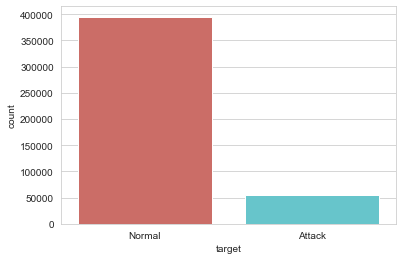

Normal    395298
Attack     54621
Name: target, dtype: int64

<Figure size 432x288 with 0 Axes>

In [407]:
# Посмотрим на распределение целевой переменной
sns.countplot(x = 'target', data = df, palette = 'hls')
plt.show()
plt.savefig('count_target')
df['target'].value_counts()

In [408]:
# Посмотрим процентное соотношение принимаемых значений целевой переменной
df.target.value_counts(normalize=True)

Normal    0.878598
Attack    0.121402
Name: target, dtype: float64

In [409]:
df.groupby('target').mean()

,FIT101,LIT101,MV101,P101,P102,AIT201,AIT202,AIT203,FIT201,MV201,P201,P203,P204,P205,P206,DPIT301,FIT301,LIT301,MV301,MV302,MV303,MV304,P302,AIT401,AIT402,FIT401,LIT401,P402,P403,UV401,AIT501,AIT502,AIT503,AIT504,FIT501,FIT502,FIT503,FIT504,P501,PIT501,PIT502,PIT503,FIT601,P602,day_sin,day_cos,month_sin,month_cos,hour_sin,hour_cos
target,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Attack,0.788088,727.417799,1.306530,1.271269,1.055455,202.227253,8.546089,337.135281,0.689176,1.281595,1.013530,1.267150,1.001025,1.270409,1.001007,8.412123,0.663014,964.958920,1.012596,1.294191,1.016093,1.632229,1.297560,148.806887,250.777222,0.668140,497.879126,1.414639,1.000000,1.391553,7.656288,188.299815,266.585898,16.621171,0.701738,0.523756,0.292724,0.117979,1.391626,106.717848,0.463409,78.508043,0.011338,1.006188,-0.005186,0.999797,0.048562,0.986988,0.662466,0.008082
Normal,1.842334,590.383784,1.714914,1.751560,1.000243,211.412396,8.526110,317.975438,1.842982,1.748236,1.135928,1.749212,1.000000,1.749265,1.000000,16.852286,1.858716,902.493368,1.006592,1.812589,1.024351,1.027782,1.838633,148.805713,149.721822,1.717623,879.923850,1.999836,1.000152,1.999676,7.805469,141.873725,264.541471,14.211491,1.727549,1.288277,0.732999,0.306720,1.999681,249.508917,1.089405,188.007979,0.017289,1.009502,-0.008686,0.999583,0.170877,0.954214,0.613888,-0.101149


- **количественные признаки**

In [410]:
# Посмотрим сколько выбросов в новых признаках
time_cols = ['month_sin', 'month_cos', 'hour_sin', 'hour_cos', 'day_cos', 'day_sin']
for col in time_cols:
    IQR_outlier(df, col, verbose=True)
    print()

Для признака month_sin :
25-й перцентиль: -2.4492935982947064e-16 75-й перцентиль: 0.49999999999999994, IQR: 0.5000000000000002,  Границы выбросов: [-0.7500000000000006, 1.2500000000000002].
Выбросов, согласно IQR: 0 | 0.00%

Для признака month_cos :
25-й перцентиль: 0.8660254037844387 75-й перцентиль: 1.0, IQR: 0.1339745962155613,  Границы выбросов: [0.6650635094610968, 1.200961894323342].
Выбросов, согласно IQR: 0 | 0.00%

Для признака hour_sin :
25-й перцентиль: 0.258819045102521 75-й перцентиль: 0.8660254037844388, IQR: 0.6072063586819179,  Границы выбросов: [-0.6519904929203557, 1.7768349418073157].
Выбросов, согласно IQR: 0 | 0.00%

Для признака hour_cos :
25-й перцентиль: -0.8660254037844387 75-й перцентиль: 0.7071067811865476, IQR: 1.5731321849709863,  Границы выбросов: [-3.2257236812409182, 3.066805058643027].
Выбросов, согласно IQR: 0 | 0.00%

Для признака day_cos :
25-й перцентиль: 0.9994074007397048 75-й перцентиль: 0.9998518392091162, IQR: 0.0004444384694114456,  Границы в

In [411]:
# Посмотрим сколько выбросов в количественных признаках
for col in num_cols:
    IQR_outlier(df, col, verbose=True)
    print()

Для признака FIT101 :
25-й перцентиль: 0.0 75-й перцентиль: 2.577907, IQR: 2.577907,  Границы выбросов: [-3.8668605000000005, 6.444767500000001].
Выбросов, согласно IQR: 0 | 0.00%

Для признака LIT101 :
25-й перцентиль: 510.0111 75-й перцентиль: 727.4321, IQR: 217.421,  Границы выбросов: [183.87960000000004, 1053.5636].
Выбросов, согласно IQR: 0 | 0.00%

Для признака AIT201 :
25-й перцентиль: 177.102 75-й перцентиль: 253.8452, IQR: 76.7432,  Границы выбросов: [61.9872, 368.96000000000004].
Выбросов, согласно IQR: 0 | 0.00%

Для признака AIT202 :
25-й перцентиль: 8.441618 75-й перцентиль: 8.610806, IQR: 0.16918800000000012,  Границы выбросов: [8.187836, 8.864588000000001].
Выбросов, согласно IQR: 199 | 0.04%

Для признака AIT203 :
25-й перцентиль: 306.383 75-й перцентиль: 331.6842, IQR: 25.301199999999994,  Границы выбросов: [268.4312, 369.63599999999997].
Выбросов, согласно IQR: 2987 | 0.66%

Для признака FIT201 :
25-й перцентиль: 0.0 75-й перцентиль: 2.454362, IQR: 2.454362,  Границы 

In [412]:
# Произведём нормировку данных, для чего прологарифмируем числовые переменные, 
# чтобы сгладить разницу в размерности и, возможно, уменьшить выбросы

for col in num_cols:
    df[col] = df[col].apply(lambda x: np.log(x + 1))

- **категориальные признаки**

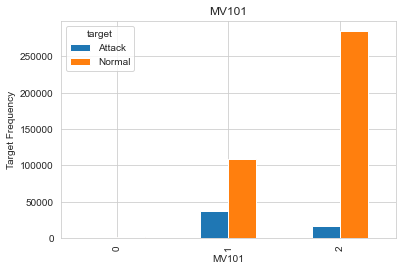

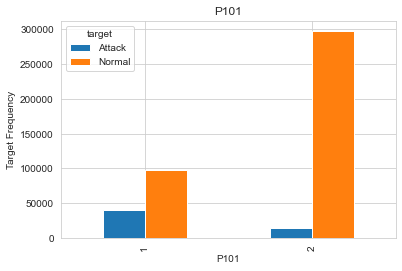

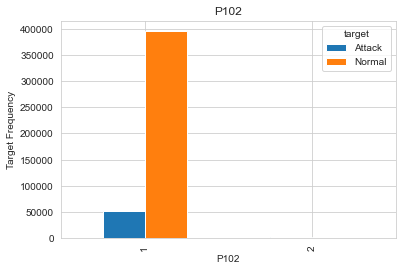

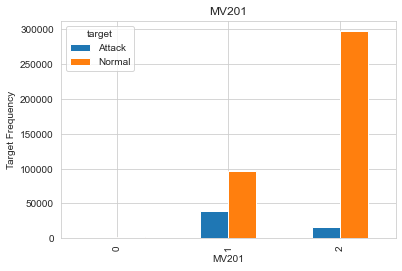

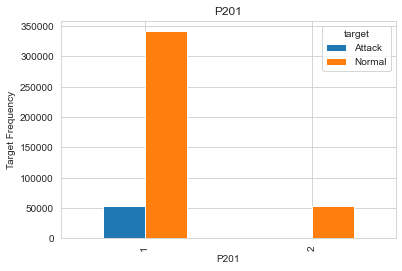

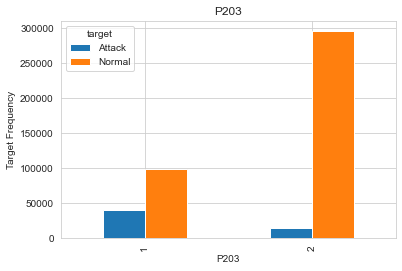

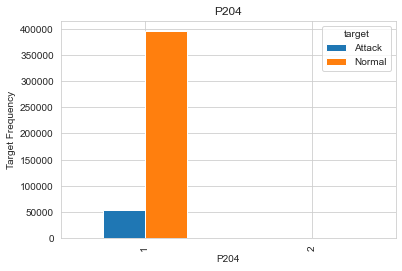

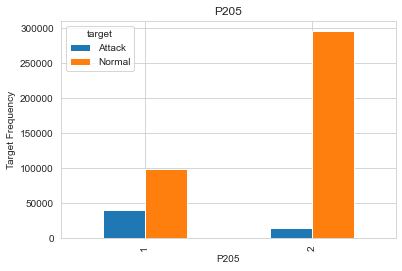

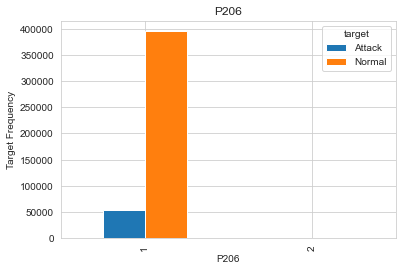

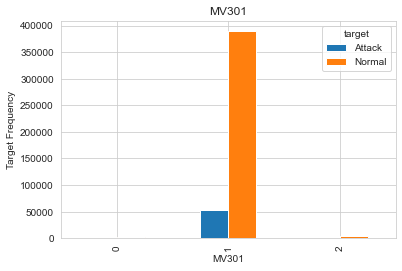

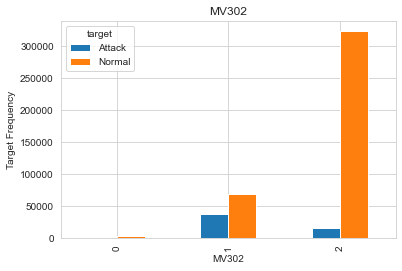

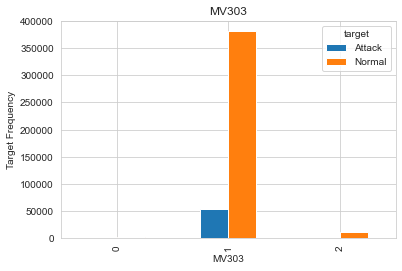

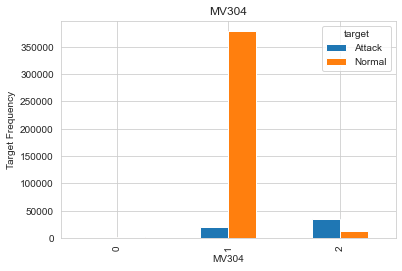

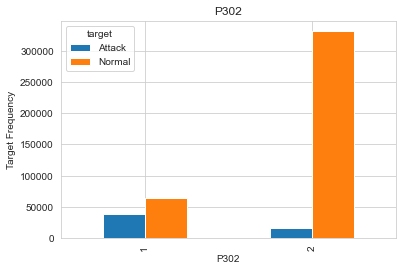

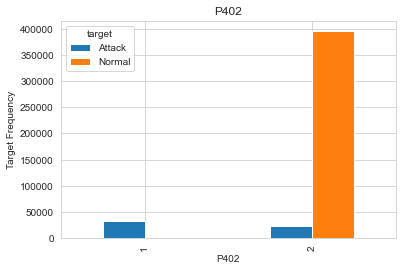

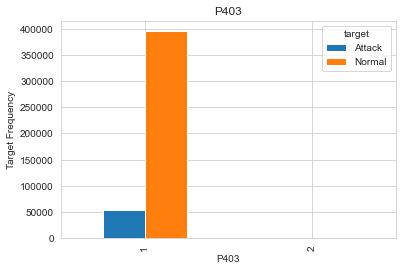

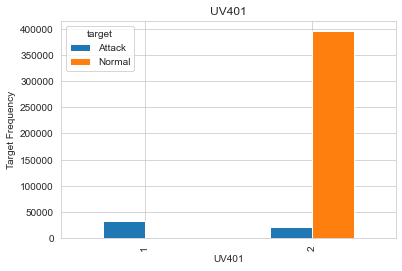

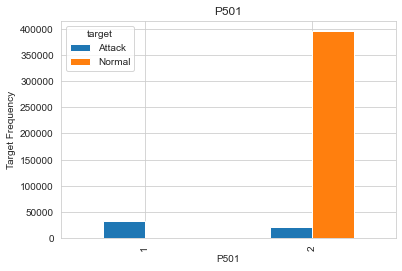

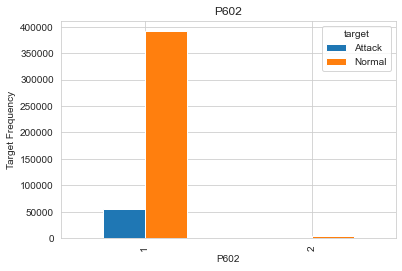

In [413]:
# Соотношение Attack/Normal для категориальных признаков
for col in cat_cols:
    pd.crosstab(df[col],df['target']).plot(kind='bar')
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('Target Frequency')
    plt.savefig('target_per_cat')

In [414]:
# Целевая переменная у нас это бинарный признак. Для неё мы будем использовать LabelEncoder
label_encoder = LabelEncoder()
df['target'] = label_encoder.fit_transform(df['target'])

## LogisticRegression

- **Подготовка датасета для регрессии**

In [415]:
df_1 = df.copy()

In [416]:
# Для категориальных признаков мы будем использовать OneHotEncoder
encoder = OneHotEncoder(sparse = False)
X_cat = encoder.fit_transform(df_1[cat_cols].values)

list_of_cols = encoder.get_feature_names(cat_cols).tolist()
X_cat_column = pd.DataFrame(X_cat, columns = list_of_cols)
df_1= pd.concat([df_1,X_cat_column],axis = 1)

df_1.drop(cat_cols, axis = 1, inplace=True)
df_1.head(2)

,Timestamp,FIT101,LIT101,AIT201,AIT202,AIT203,FIT201,DPIT301,FIT301,LIT301,AIT401,AIT402,FIT401,LIT401,AIT501,AIT502,AIT503,AIT504,FIT501,FIT502,FIT503,FIT504,PIT501,PIT502,PIT503,FIT601,target,day_sin,day_cos,month_sin,month_cos,hour_sin,hour_cos,MV101_0,MV101_1,MV101_2,P101_1,P101_2,P102_1,P102_2,MV201_0,MV201_1,MV201_2,P201_1,P201_2,P203_1,P203_2,P204_1,P204_2,P205_1,P205_2,P206_1,P206_2,MV301_0,MV301_1,MV301_2,MV302_0,MV302_1,MV302_2,MV303_0,MV303_1,MV303_2,MV304_0,MV304_1,MV304_2,P302_1,P302_2,P402_1,P402_2,P403_1,P403_2,UV401_1,UV401_2,P501_1,P501_2,P602_1,P602_2
0,2015-12-28 10:00:00,1.231702,6.261199,5.572215,2.240331,5.797982,1.237037,3.032468,1.165284,6.863976,5.009354,5.056807,0.998246,6.849136,2.183646,4.984405,5.581794,2.567667,1.002024,0.824009,0.551162,0.268336,5.528894,0.974542,5.250171,0.000128,1,-0.05162,0.998667,-2.449294e-16,1.0,0.5,-0.866025,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
1,2015-12-28 10:00:01,1.237294,6.261274,5.572215,2.240331,5.797982,1.237037,3.032468,1.165724,6.863976,5.009354,5.056807,0.999143,6.849096,2.183646,4.984405,5.581794,2.567667,1.002024,0.831845,0.551162,0.268336,5.528894,0.974542,5.250591,0.000128,1,-0.05162,0.998667,-2.449294e-16,1.0,0.5,-0.866025,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0


In [417]:
# Уберём из рассмотрения признак времени
df_1 = df_1.loc[:, df_1.columns != 'Timestamp']

In [418]:
# Разделим датасет на матрицу признаков и матрицу целевой переменной
X = df_1.loc[:, df_1.columns != 'target']
y = df_1['target'].values

In [419]:
# выделим 30% данных на тестовую выборку (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

In [420]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((314943, 75), (134976, 75), (314943,), (134976,))

In [421]:
#Нормализация численных данных
scaler = StandardScaler()

# Для обучающей выборки
X_train_st = scaler.fit_transform(X_train)

# Для тестовой выборки 
X_test_st = scaler.transform(X_test)

In [422]:
#Обучаем модель
logreg_0 = LogisticRegression(random_state=RANDOM_SEED)
logreg_0.fit(X_train_st, y_train)

LogisticRegression(random_state=42)

In [423]:
y_pred = logreg_0.predict(X_test_st)

In [424]:
# Покажем значение accuracy
accuracy_score(y_test, y_pred)

0.9716912636320532

In [425]:
# Посмотрим на метрики
from sklearn.metrics import classification_report
classification_report = classification_report(y_test, y_pred)
print(classification_report)

              precision    recall  f1-score   support

           0       0.98      0.78      0.87     16386
           1       0.97      1.00      0.98    118590

    accuracy                           0.97    134976
   macro avg       0.97      0.89      0.93    134976
weighted avg       0.97      0.97      0.97    134976



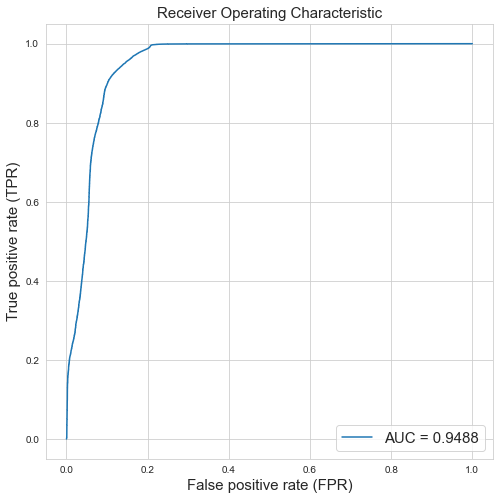

In [426]:
# Отрисовать ROC кривую
y_pred_proba = logreg_0.predict_proba(X_test_st)
calc_and_plot_roc(y_test, y_pred_proba[:, 1])

In [427]:
#Построение матрицы ошибок
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
(tn, fp, fn, tp)

(12861, 3525, 296, 118294)

- **Находим оптимальные гиперпараметры с помощью optuna**

In [429]:
study = optuna.create_study(direction='maximize')

n_trials = 20
for _ in range(n_trials):
    trial = study.ask()

    C = trial.suggest_loguniform('C', 1e-7, 10.0)
    solver = trial.suggest_categorical('solver', ('lbfgs', 'saga'))

    clf = LogisticRegression(C=C, solver=solver)
    clf.fit(X_train_st, y_train)
    val_accuracy = clf.score(X_test_st, y_test)

    study.tell(trial, val_accuracy)

[I 2022-05-19 21:25:52,524] A new study created in memory with name: no-name-31725ae7-dbfe-4904-8bdb-3d330e3d0792


In [443]:
optuna.visualization.plot_param_importances(study)

In [431]:
optuna.visualization.plot_optimization_history(study)

In [444]:
study.best_params

{'C': 0.3050607786145075, 'solver': 'lbfgs'}

In [445]:
#Обучаем модель
logreg_1 = LogisticRegression(random_state=RANDOM_SEED, solver='lbfgs', C=0.3050607786145075)
logreg_1.fit(X_train_st, y_train)

LogisticRegression(C=0.3050607786145075, random_state=42)

In [446]:
y_pred = logreg_1.predict(X_test_st)

In [447]:
accuracy_score(y_test, y_pred)

0.9718468468468469

Метрика **accuracy_score** улучшилась незначительно

## CatBoostClassifier

- Подготовка датасета для CatBoostClassifier

In [436]:
df_2 = df.copy()

In [437]:
# Уберём на этом этапе из рассмотрения признак времени
df_2 = df_2.loc[:, df_2.columns != 'Timestamp']

In [438]:
# Разделим датасет на матрицу признаков и матрицу целевой переменной
X_cat = df_2.loc[:, df_2.columns != 'target']
y_cat = df_2['target'].values

In [439]:
# выделим 30% данных на тестовую выборку (параметр test_size)
X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(
    X_cat, y_cat, test_size=0.3, random_state=0, stratify=y_cat)

In [440]:
#Нормализация численных данных
scaler_cat = StandardScaler()

# Для обучающей выборки
X_train_cat_st = scaler_cat.fit_transform(X_train_cat)

# Для тестовой выборки 
X_test_cat_st = scaler_cat.transform(X_test_cat)

In [441]:
CatBoostCl_model = CatBoostClassifier(iterations=3000,
                        depth=6,
                        learning_rate=0.01,
                        custom_loss=['Accuracy'],
                        eval_metric='Accuracy',       
                        verbose=True, 
                        use_best_model=True,
                        task_type='CPU')
CatBoostCl_model.fit(X_train_cat_st, y_train_cat, eval_set = (X_test_cat_st, y_test_cat
                                                             ), early_stopping_rounds=50, plot=False)

0:	learn: 0.9621297	test: 0.9621636	best: 0.9621636 (0)	total: 110ms	remaining: 5m 29s
1:	learn: 0.9625583	test: 0.9625563	best: 0.9625563 (1)	total: 242ms	remaining: 6m 2s
2:	learn: 0.9631362	test: 0.9630897	best: 0.9630897 (2)	total: 303ms	remaining: 5m 3s
3:	learn: 0.9660319	test: 0.9661273	best: 0.9661273 (3)	total: 408ms	remaining: 5m 5s
4:	learn: 0.9631870	test: 0.9631860	best: 0.9661273 (3)	total: 471ms	remaining: 4m 42s
5:	learn: 0.9629870	test: 0.9630156	best: 0.9661273 (3)	total: 529ms	remaining: 4m 23s
6:	learn: 0.9660764	test: 0.9661051	best: 0.9661273 (3)	total: 589ms	remaining: 4m 12s
7:	learn: 0.9641364	test: 0.9640751	best: 0.9661273 (3)	total: 726ms	remaining: 4m 31s
8:	learn: 0.9650826	test: 0.9650975	best: 0.9661273 (3)	total: 791ms	remaining: 4m 23s
9:	learn: 0.9685975	test: 0.9685277	best: 0.9685277 (9)	total: 861ms	remaining: 4m 17s
10:	learn: 0.9687308	test: 0.9687055	best: 0.9687055 (10)	total: 926ms	remaining: 4m 11s
11:	learn: 0.9690452	test: 0.9690315	best: 0

In [442]:
prediction = CatBoostCl_model.predict(X_test_cat_st)
accuracy_score(y_test_cat, prediction)

0.9986367946894262

Метрика **accuracy_score** улучшилась значительно.

**Замечание:** если из модели выбросить новые созданные признаки времени, то значение accuracy для модели CatBoostClassifier и LogisticRegression будет сравнимо друг с другом и равно приблизительно **0.97** 

Модель принимает ряд параметров, здесь показаны не все параметры. Для более тонкой настройке можно обратиться к документации, но, как правило, она не требуется. CatBoost хорошо работает из коробки, с минимальным тюнингом.

**Кратко опишем параметры модели:**

- **iterations** — максимальное количество деревьев в модели. Поскольку с каждой итерацией модель наращивает количество слабых моделей (деревьев), то этот параметр следует выставлять с запасом. Из практики, для данного конкретного примера, 3000 итераций являются достаточными и даже избыточными.
- **depth**  — глубина каждого дерева. Чем меньше, тем модель получается более грубой, уменьшая количество сделок на выходе. Глубина в диапазоне 6-10 является оптимальным решением.
- **learning_rate**  — величина шага градиента, принцип тот же что в нейронных сетях. Разумный диапазон параметров 0.01 - 0.1. Чем ниже, тем дольше модель обучается, но может найти более оптимальный вариант.
- **custom_loss, eval_metric**  — метрика, по которой происходит оценка модели. Для классификации классической метрикой является ***accuracy***
- **use_best_model**  — на каждом шаге обучения модель оценивает accuracy, который может изменяться со временем. Данный флаг позволяет сохранять модель с наименьшей ошибкой, иначе будет сохранена модель, полученная на последней итерации.
- **task_type**  — позволяет обучать модель на видеокарте, по умолчанию 'CPU'. Актуально только в случае очень больших данных, иначе на ядрах видеокарты обучается медленнее, чем на процессоре.
- **early_stopping_rounds**  — в модель встроен так называемый overfitting detector (детектор переобучения), который работает по простому принципу. Если метрика перестала уменьшаться\увеличиваться (в случае accuracy — увеличиваться) в течение заданного количества итераций, то обучение останавливается.

## Стекинг

In [330]:
# Составим список моделей для стекинга
models = list()
models.append(('lr', LogisticRegression(random_state=RANDOM_SEED, C=0.3050607786145075)))
models.append(('cbc', CatBoostClassifier(iterations=1000,
                        depth=6,
                        learning_rate=0.01,
                        custom_loss=['Accuracy'],
                        eval_metric='Accuracy',       
                        verbose=True,
                        task_type='CPU')))

In [331]:
# обучаем все модели на обучающей выборке и прогнозируем на тестовой
meta_X = list()
for name, model in models:
    model.fit(X_train, y_train)
    yhat = model.predict(X_test)
    yhat = yhat.reshape(len(yhat), 1) 
    meta_X.append(yhat) # сохраняем наши предсказания в качестве входных данных для blending

0:	learn: 0.9681815	total: 94.2ms	remaining: 1m 34s
1:	learn: 0.9654096	total: 148ms	remaining: 1m 13s
2:	learn: 0.9667813	total: 191ms	remaining: 1m 3s
3:	learn: 0.9652255	total: 238ms	remaining: 59.2s
4:	learn: 0.9662764	total: 281ms	remaining: 55.8s
5:	learn: 0.9665781	total: 355ms	remaining: 58.7s
6:	learn: 0.9653620	total: 408ms	remaining: 57.9s
7:	learn: 0.9651492	total: 455ms	remaining: 56.4s
8:	learn: 0.9652064	total: 496ms	remaining: 54.6s
9:	learn: 0.9663844	total: 536ms	remaining: 53.1s
10:	learn: 0.9677084	total: 600ms	remaining: 53.9s
11:	learn: 0.9651429	total: 656ms	remaining: 54s
12:	learn: 0.9651683	total: 703ms	remaining: 53.4s
13:	learn: 0.9651778	total: 746ms	remaining: 52.5s
14:	learn: 0.9651619	total: 790ms	remaining: 51.9s
15:	learn: 0.9651842	total: 863ms	remaining: 53.1s
16:	learn: 0.9651905	total: 911ms	remaining: 52.7s
17:	learn: 0.9677529	total: 954ms	remaining: 52s
18:	learn: 0.9676449	total: 995ms	remaining: 51.4s
19:	learn: 0.9677561	total: 1.04s	remainin

In [332]:
# создадим 2d array для предсказанных значений, каждый набор предсказаний будет отдельным признаком
meta_X = np.hstack(meta_X)

In [335]:
# определим смешанную модель
blender = LogisticRegression()
blender.fit(meta_X, y_test)

LogisticRegression()

In [336]:
y_pred = blender.predict(meta_X)

In [337]:
accuracy_score(y_test, y_pred)

0.9959696538643907